In [107]:
import numpy as np
import matplotlib.pyplot as plt
import io
import torch.nn as nn
import torch
import umap.plot
from umap.umap_ import UMAP
import pandas as pd
import scipy
import seaborn as sns
from tqdm import tqdm

## Generate UMAP embedding

In [96]:
val_data = np.load("val_data.npy", allow_pickle=True)

In [ ]:
val_data[34983][0].shape

In [ ]:
all_x = np.array([x[0].reshape(28,28).flatten() for x in val_data])

In [ ]:
embedding = UMAP().fit(all_x);

In [ ]:
df = pd.DataFrame(embedding.embedding_, columns = ['x', 'y'])

In [ ]:
df.plot.scatter(x='x', y='y')

In [ ]:
all_y = np.array([x[1] for x in val_data])

In [104]:
classes = ['airplane',
           'apple',
           'bee',
           'car',
           'dragon',
           'mosquito',
           'moustache',
           'mouth',
           'pear',
           'piano',
           'pineapple',
           'smiley face',
           'train',
           'umbrella',
           'wine bottle']

In [ ]:
df['class'] = all_y

In [ ]:
df['class_name'] = df['class'].apply(lambda x: classes[x])

In [105]:
model = nn.Sequential(
    nn.Conv2d(1, 16, 3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 32, 3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 32, 3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(288, 128),
    nn.ReLU(),
    nn.Linear(128, len(classes)),
)

checkpoint = torch.load('./model_lessCapacity.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)

model.eval()

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=288, out_features=128, bias=True)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=15, bias=True)
)

In [13]:
results = []

In [42]:
layer = 0
idx = 3290
model.train()

x = torch.autograd.Variable(torch.tensor(val_data[idx][0]), requires_grad=True).unsqueeze(dim=0)
intermediate = model[:layer](x)
intermediate.retain_grad()
y = model[layer:](intermediate)
model.zero_grad()
y.sum().backward()
grad = intermediate.grad.cpu()[0]
results.append([idx, (intermediate * grad).detach().numpy()])

model.eval()

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=288, out_features=128, bias=True)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=15, bias=True)
)

In [43]:
intermediate.requires_grad

True

In [ ]:
y_hats = []
for sketch_index in range(300000):
    x = val_data[sketch_index][0]
    logits = model(torch.tensor(x).unsqueeze(1))
    y_hat = np.argmax(logits.detach().numpy())
    y_hats.append(y_hat)

In [ ]:
df['predicted'] = y_hats

In [ ]:
df['predicted_name'] = df['predicted'].apply(lambda x: classes[x])

In [ ]:
df.head()

In [ ]:
#df.to_csv('umap.csv')

## UMAP Last Conv Layer

In [ ]:
last_cl_representations = []
for sketch_index in range(300000):
    x = val_data[sketch_index][0]
    last_cl = model[:7](torch.tensor(x).unsqueeze(1))
    last_cl_representations.append(last_cl)

In [ ]:
last_cl_np = np.array(list(map(lambda tensor: tensor.squeeze(0).detach().numpy().flatten(), last_cl_representations)))



In [2]:
last_cl_np = np.load("last_convolutional_layer.npy", allow_pickle=True)

In [8]:
embedding_cl = UMAP().fit(last_cl_np);

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [5]:
val_data = np.load("val_data.npy", allow_pickle=True)

In [37]:
np.vstack(val_data[:,0]).reshape(300000,784)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [9]:
df_cl = pd.DataFrame(embedding_cl.embedding_, columns = ['x', 'y'])    

In [11]:
df_cl.shape

(300000, 2)

In [27]:
df_cl.to_csv('umap_cl.csv')

In [13]:
umap_df = pd.read_csv("./umap.csv")

In [3]:
lcl_data = np.load("last_convolutional_layer.npy", allow_pickle=True)

In [41]:
lcl_data.reshape(300000, 1568)

array([[-0.23942018, -0.0716604 , -0.17281221, ..., -0.79403675,
        -0.88329726, -0.1762782 ],
       [-0.0515552 , -0.18249641, -0.26392174, ..., -0.09757087,
        -0.06598158, -0.20029654],
       [-0.2814567 , -0.40393028, -0.26490128, ..., -0.18941976,
        -0.09301576, -0.17999679],
       ...,
       [-0.06057782, -0.19995815, -0.39283985, ...,  0.08945549,
        -0.19394016, -0.15051356],
       [-0.19891332, -0.5534772 , -0.45813707, ..., -0.06628023,
        -0.05213711, -0.18886098],
       [ 0.9122118 ,  0.06267405, -0.55723274, ...,  0.11979336,
        -0.07012907, -0.10183923]], dtype=float32)

In [6]:
x.reshape(28,28,1)

NameError: name 'x' is not defined

In [5]:
lcl_data[0].shape

(1568,)

In [32]:
extended_df = pd.concat([umap_df, df_cl], axis=1)[['x','y','class','class_name','predicted','predicted_name','x_cl','y_cl']]



In [33]:
extended_df.to_csv('umap_extended.csv')

In [34]:
extended_df.head()

,x,y,class,class_name,predicted,predicted_name,x_cl,y_cl
0,10.439865,11.399223,14,wine bottle,14,wine bottle,10.261770,12.589383
1,-1.522812,9.091824,9,piano,9,piano,-1.679909,6.546764
2,-0.078322,6.752753,9,piano,9,piano,-2.918781,5.499226
3,-1.777769,8.416865,12,train,12,train,-1.568735,6.539262
4,3.492680,4.150504,11,smiley face,11,smiley face,4.227337,5.325876


In [36]:
extended_df[(extended_df.x > 10) & (extended_df.x < 10.1) & (extended_df.y > 10) & (extended_df.y < 10.1) ]

,x,y,class,class_name,predicted,predicted_name,x_cl,y_cl
459,10.058564,10.078728,10,pineapple,10,pineapple,8.655949,10.818340
7635,10.029596,10.046811,10,pineapple,10,pineapple,7.941402,10.687274
11596,10.047059,10.005007,10,pineapple,10,pineapple,8.628550,10.716096
13050,10.058895,10.094740,10,pineapple,10,pineapple,8.575015,10.723920
14394,10.071191,10.006775,10,pineapple,10,pineapple,8.515562,10.763453
30509,10.075893,10.012474,10,pineapple,10,pineapple,8.249722,10.346437
42004,10.096755,10.003428,10,pineapple,10,pineapple,8.731153,10.892737
45274,10.086960,10.062394,10,pineapple,10,pineapple,8.645429,10.264174
49545,10.000556,10.037330,10,pineapple,10,pineapple,8.363608,10.825409
52399,10.057635,10.088057,10,pineapple,10,pineapple,8.495973,10.942862


In [125]:
def get_df_intermediate_representation(layer, model, data):
    results = []
    model.train()
    for idx in tqdm(range(len(data))):
        x = torch.autograd.Variable(torch.tensor(data[idx][0]), requires_grad=True).unsqueeze(dim=0)
        intermediate = model[:layer](x)
        intermediate.retain_grad()
        y = model[layer:](intermediate).sum()
        model.zero_grad()
        y.backward()
        grad = intermediate.grad.cpu()[0]
        results.append([idx, (intermediate).detach().numpy()])

    df = pd.DataFrame(results, columns=["idx", "intermediate"])
    df = df.set_index("idx")
    model.eval()
    return df

In [112]:
def get_df_intermediate_representation_with_grad(layer, model, data):
    results = []
    model.train()
    for idx in tqdm(range(len(data))):
        x = torch.autograd.Variable(torch.tensor(data[idx][0]), requires_grad=True).unsqueeze(dim=0)
        intermediate = model[:layer](x)
        intermediate.retain_grad()
        y = model[layer:](intermediate).sum()
        model.zero_grad()
        y.backward()
        grad = intermediate.grad.cpu()[0]
        results.append([idx, (intermediate * grad).detach().numpy()])

    df = pd.DataFrame(results, columns=["idx", "intermediate"])
    df = df.set_index("idx")
    model.eval()
    return df

In [46]:
from tqdm import tqdm

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 790.01it/s]


(6272,)
                                          intermediate
idx                                                   
0    [[[[-0.27292344 -0.33935237 -0.29095656  0.003...
1    [[[[-0.27292344 -0.33935237 -0.33935237 -0.339...
2    [[[[-0.27292344 -0.33935237 -0.33935237 -0.339...
3    [[[[-0.27292344 -0.33935237 -0.33935237 -0.339...
4    [[[[-0.27292344 -0.33935237 -0.33935237 -0.339...
..                                                 ...
995  [[[[-0.27292344 -0.33935237 -0.33935237 -0.339...
996  [[[[-0.26983058 -0.34762153 -0.39911062 -0.407...
997  [[[[-0.27292344 -0.33935237 -0.33935237 -0.339...
998  [[[[-0.27292344 -0.33935237 -0.33692607 -0.320...
999  [[[[-0.27292344 -0.33935237 -0.33935237 -0.339...

[1000 rows x 1 columns]


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 770.32it/s]


(6272,)
                                          intermediate
idx                                                   
0    [[[[-0.         -0.         -0.         -0.004...
1    [[[[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0...
2    [[[[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0...
3    [[[[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0...
4    [[[[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0...
..                                                 ...
995  [[[[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0...
996  [[[[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0...
997  [[[[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0...
998  [[[[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0...
999  [[[[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0...

[1000 rows x 1 columns]


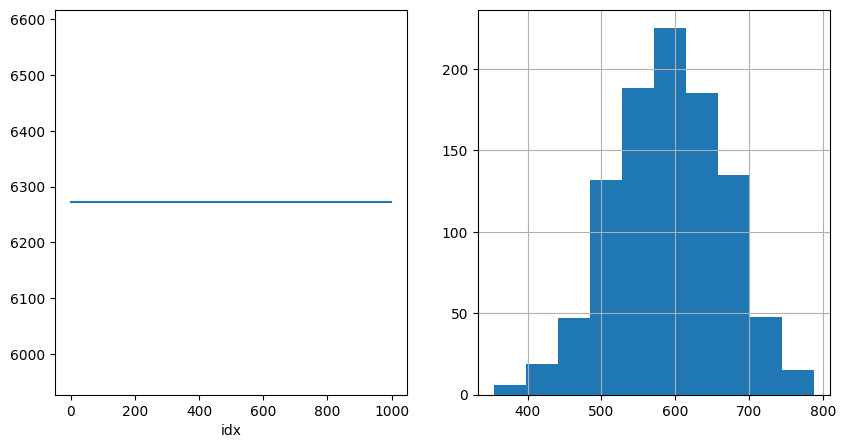

In [122]:
layer = 4

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


x = get_df_intermediate_representation(layer, model, val_data[0:1000])
print(x.intermediate[0].flatten().shape)
x.intermediate.apply(np.count_nonzero).plot(ax = ax1)
print(x)

x = get_df_intermediate_representation_with_grad(layer, model, val_data[0:1000])
print(x.intermediate[0].flatten().shape)
x.intermediate.apply(np.count_nonzero).hist(ax = ax2)
print(x)

In [126]:
def get_knn_tree(df):
    knn_input = np.stack(df["intermediate"].apply(lambda x: x.flatten()))
    tree = scipy.spatial.cKDTree(knn_input)
    return tree

In [131]:
l0 = get_df_intermediate_representation(0, model, val_data[0:1000])
t0 = get_knn_tree(l0)

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 789.34it/s]


In [ ]:
dd1, ii1 = t1.query(query, k=list(range(k + 1))[1:])

In [137]:
query = l0.intermediate.iloc[0].flatten()

In [139]:
t0.query(query, k=list(range(50))[1:])

(array([0.        , 7.84563396, 8.11140998, 8.4124832 , 8.44409441,
        8.47873431, 8.53056476, 8.54013936, 8.54181478, 8.63764912,
        8.69833454, 8.71497588, 8.80302196, 8.86067566, 8.90031259,
        8.97123693, 9.03390515, 9.1444927 , 9.14995168, 9.16723689,
        9.26083648, 9.29393154, 9.30105232, 9.34038952, 9.34906737,
        9.36436355, 9.36477493, 9.38260767, 9.39701957, 9.41026954,
        9.48002378, 9.51062142, 9.5760997 , 9.58459698, 9.58827947,
        9.59768337, 9.64893817, 9.65696054, 9.65862299, 9.67761468,
        9.69136888, 9.736699  , 9.76422558, 9.76969482, 9.80262036,
        9.81473528, 9.84434731, 9.8583899 , 9.86496764]),
 array([  0, 254, 909, 830, 269, 700, 409, 322, 718, 181, 827, 922, 783,
         93, 804, 457, 291, 488, 948, 987, 695, 608, 349, 236, 268, 213,
        648, 169, 455, 682,  54, 342, 862, 659, 389, 233, 151, 824, 732,
        276, 733,  95, 636, 657, 167, 900, 490, 603, 501]))

In [212]:
base_x = pd.read_csv('base.csv')

In [181]:
help(base_slim.rename)

Help on method rename in module pandas.core.frame:

rename(mapper: 'Renamer | None' = None, *, index: 'Renamer | None' = None, columns: 'Renamer | None' = None, axis: 'Axis | None' = None, copy: 'bool | None' = None, inplace: 'bool' = False, level: 'Level' = None, errors: 'IgnoreRaise' = 'ignore') -> 'DataFrame | None' method of pandas.core.frame.DataFrame instance
    Alter axes labels.
    
    Function / dict values must be unique (1-to-1). Labels not contained in
    a dict / Series will be left as-is. Extra labels listed don't throw an
    error.
    
    See the :ref:`user guide <basics.rename>` for more.
    
    Parameters
    ----------
    mapper : dict-like or function
        Dict-like or function transformations to apply to
        that axis' values. Use either ``mapper`` and ``axis`` to
        specify the axis to target with ``mapper``, or ``index`` and
        ``columns``.
    index : dict-like or function
        Alternative to specifying axis (``mapper, axis=0``
     

In [6]:
base_df3

,0-0,0-1,0-2,0-3,0-4,0-5,0-6,0-7,0-8,0-9,...,13-990,13-991,13-992,13-993,13-994,13-995,13-996,13-997,13-998,13-999
idx,,,,,,,,,,,,,,,,,,,,,
165822,0,2130,6194,1320,1892,3228,6036,8803,389,9653,...,9151,7566,7398,5225,8900,5954,5925,154,3525,694
222452,1,645,7268,6076,41,5105,4562,6872,3236,3610,...,5793,9794,7711,6854,1219,1682,6850,2015,539,8074
43398,2,7998,3924,4657,7506,3808,331,66,6686,5064,...,9766,7973,4543,2517,3704,3578,5894,3877,8592,3508
184890,3,5905,3059,6167,2582,7132,6076,8601,3524,4435,...,7796,5098,9291,5547,838,5934,8799,4623,8796,3957
217562,4,2989,6765,3786,4712,1984,8964,4451,9811,5133,...,2294,1333,4648,5937,4531,6464,4869,8970,5314,4513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265860,9995,6265,9224,3711,5016,6803,9503,2649,6203,4688,...,1955,6500,3386,481,401,2637,5354,3271,5413,9837
186450,9996,251,9432,1008,3166,9,8663,2757,1954,2315,...,6488,8011,1993,1728,4054,8341,3445,883,1544,7715
261450,9997,4089,4570,2029,3987,428,9882,6381,4642,6845,...,2563,5918,7049,1761,1959,7806,3274,8738,5993,7519


In [3]:
base_df3 = pd.read_csv('base_slim.csv', index_col="idx")

In [7]:
icons = {}

In [12]:
import base64

In [54]:
px = 1 / plt.rcParams['figure.dpi']  # pixel in inches
fig = plt.figure(figsize=(1,1), dpi=28)
plt.tight_layout()
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
x = val_data[257353][0].reshape(28, 28, 1)
ax.imshow(x, cmap='Greys', alpha=x.reshape(28, 28))
buf = io.BytesIO()

fig.savefig(buf, format='png', bbox_inches='tight', transparent=True, dpi=28)
plt.close(fig)
buf.seek(0)

base64.b64encode(buf.getvalue()).decode()

'iVBORw0KGgoAAAANSUhEUgAAACEAAAAhCAYAAABX5MJvAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy88F64QAAAACXBIWXMAAAROAAAETgFCi5P8AAAFrklEQVR4nO2XfUxTVxTAz+t7fXy0bgX5aAQaqdItgzhYtDMQ+YMFQlyWuCgNGIJkBoYxyIc1ZSxxzLgwwIYsFJMNURYzZUDWbEy36UKGJjCdDAaNJIh8Sa0WX/loaeG9vnf2z5qQpkjLsugfu8n5495z7rm/d+6957xLICK86CZ60QAALwkEFegEjuNCEVFE07Tjn37I/Pz8dpvNJn/69GmMIAgitVr9s0QisfrtFBH9koWFBUV9fX19WFjYQmFh4ff3799/p6SkpIOm6VUAwLVCkqQ7Nzf3lxs3bnywuroq3cj3ugqz2fymSqWaYBhmp1arvUhRFLd2EQDAmJgYi16vr+3t7T3c3d394ZUrVyp1Ol1LREQE47FVKBTmW7du5W0KwuFwRNM0vSqXy60kSbobGxs/S0hImCQIQtBoNDf7+/sPWa3W15OSksY8UM+Turq6hoAhEBHKysouAwAajcbjiAizs7PJDMPsRESYn5+PdzqdW0+ePHkpPT19QCQS8SRJus+dO/e52+0WIyIsLi7G9vT0FOTk5PxKkqTb5XLJAoaw2+3yO3fuvO893t/ffwgAMDU1dej69etFgiAQc3NzKq1We5EgCCEjI+Pu3NycymMvCALhcDiiNxUJRISWlpaP9+3b92daWtqg3W6XIyIUFRV1xcXFPc7Ozu6jKIpbWlqK8dibTKZMhUJhDg0NdXZ0dJT5c+g3NIiIiGDUavWIVCp16HS6FkSE+Pj4mZqamiaWZUNYlg31cZ6iCgoKugEAKysr2wRBIDYN4XQ6wwEAm5ubawYHB98dGBh4DxHh9u3buSRJuktLS79Zb64

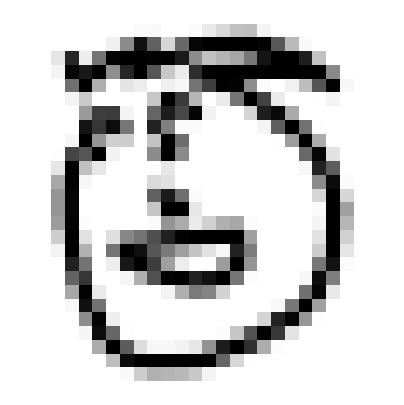

In [55]:
plot(257353)

In [56]:
for idx in base_df3.index:
    px = 1 / plt.rcParams['figure.dpi']  # pixel in inches
    fig = plt.figure(figsize=(28 * px, 28 * px))
    plt.tight_layout()
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    x = val_data[idx][0].reshape(28, 28, 1)
    ax.imshow(x, cmap='Greys', alpha=x.reshape(28, 28))
    buf = io.BytesIO()

    fig.savefig(buf, format='png', bbox_inches='tight', transparent=True)
    plt.close(fig)
    buf.seek(0)

    icons[str(idx)] = base64.b64encode(buf.getvalue()).decode()

In [57]:
icons["257353"]

'iVBORw0KGgoAAAANSUhEUgAAADAAAAAwCAYAAABXAvmHAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy88F64QAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAF3klEQVR4nO2Zf0wTZxjHn+tdK9DqCoI0FhpbbbcM4mDBzkDkDxYIcVniojZqCJIZGMYoWGvqWOKccWGAjSEUkw0RFqMyMGs2p9t0IUMzmEyGg0YSRPkhtVq8Fmhp4a53z/7YSEij05WmjQnf5P3j3vf59cm9ufe5OwIR4VWWINIFLFZLAJHWEkCktQQQaS0BRFqvPAAVymAsy8YgokAkEnn+vY52uVxrnE6n7MmTJ3Ke5wVarfYnsVjsCFlSRFz0mJycVFRXV1fHxsZOFhUVfXf37t13S0tLW0Ui0RwA4MJBkqR/x44dP1+7du3Dubk5yWJzB+Vks9ne0mg0D2iaXmcwGM5SFMUuLBAAUC6X200mU2VHR8euy5cvf3ThwgW90WhsiI+Pp+dtFQqF7caNGzvDDuDxeBJFItGcTCZzkCTpP3Xq1OdqtXqYIAhep9Nd7+rq2uZwON5ITU0dnAf6r1FVVVUTVgBEhLKysnMAgBaLZR8iwvj4eBpN0+sQEVwul9Lr9a48dOhQU3Z2do9AIOBIkvSfPHnyC7/fL0REmJqaSmpvby/cvn37LyRJ+n0+nzSsAG63W3br1q0PAue7urq2AQBmZmbeuXr1ajHP88TExITGYDCcJQiCz8nJ6Z6YmNDM2/M8T3g8nsSw3wFEhIaGhk82bdr0Z1ZWVq/b7ZYhIhQXF19KTk5+lJ+f30lRFDs9PS2ft7darbkKhcIWExPjbW1tLVtM7pAAxMfH01qttl8ikXiMRmMDIoJSqRw7duxYHcMw0QzDxAT6eDyeVYWFhZcBAPV6fTPP80REALxebxwAYH19/bHe3t73enp

In [58]:
import sys
sys.getsizeof(icons)

295000

In [83]:
base64_df = pd.DataFrame([icons.keys(), icons.values()]).T.rename(columns=dict(zip([0,1],[0,"img"]))).set_index(0)
base64_df.index = base64_df.index.astype(int)

In [78]:
sys.getsizeof(base_df3)

1120344248

In [85]:
base_df3.join(base64_df)

,0-0,0-1,0-2,0-3,0-4,0-5,0-6,0-7,0-8,0-9,...,13-991,13-992,13-993,13-994,13-995,13-996,13-997,13-998,13-999,img
idx,,,,,,,,,,,,,,,,,,,,,
165822,0,2130,6194,1320,1892,3228,6036,8803,389,9653,...,7566,7398,5225,8900,5954,5925,154,3525,694,iVBORw0KGgoAAAANSUhEUgAAADAAAAAwCAYAAABXAvmHAA...
222452,1,645,7268,6076,41,5105,4562,6872,3236,3610,...,9794,7711,6854,1219,1682,6850,2015,539,8074,iVBORw0KGgoAAAANSUhEUgAAADAAAAAwCAYAAABXAvmHAA...
43398,2,7998,3924,4657,7506,3808,331,66,6686,5064,...,7973,4543,2517,3704,3578,5894,3877,8592,3508,iVBORw0KGgoAAAANSUhEUgAAADAAAAAwCAYAAABXAvmHAA...
184890,3,5905,3059,6167,2582,7132,6076,8601,3524,4435,...,5098,9291,5547,838,5934,8799,4623,8796,3957,iVBORw0KGgoAAAANSUhEUgAAADAAAAAwCAYAAABXAvmHAA...
217562,4,2989,6765,3786,4712,1984,8964,4451,9811,5133,...,1333,4648,5937,4531,6464,4869,8970,5314,4513,iVBORw0KGgoAAAANSUhEUgAAADAAAAAwCAYAAABXAvmHAA...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265860,9995,6265,9224,3711,5016,6803,9503,2649,6203,4688,...,6500,3386,481,401,2637,5354,3271,5413,9837,iVBORw0KGgoAAAANSUhEUgAAADAAAAAwCAYAAABXAvmHAA...
186450,9996,251,9432,1008,3166,9,8663,2757,1954,2315,...,8011,1993,1728,4054,8341,3445,883,1544,7715,iVBORw0KGgoAAAANSUhEUgAAADAAAAAwCAYAAABXAvmHAA...
261450,9997,4089,4570,2029,3987,428,9882,6381,4642,6845,...,5918,7049,1761,1959,7806,3274,8738,5993,7519,iVBORw0KGgoAAAANSUhEUgAAADAAAAAwCAYAAABXAvmHAA...


In [77]:
sys.getsizeof(base_df3.join(base64_df))

1136110880

In [145]:
base_slim = base_df.filter(regex=("a.*"))

In [172]:
base_slim = pd.concat([base_slim, base_df.filter(regex=("b.*-12"))], axis=1)

['0-0',
 '0-1',
 '0-2',
 '0-3',
 '0-4',
 '0-5',
 '0-6',
 '0-7',
 '0-8',
 '0-9',
 '0-10',
 '0-11',
 '0-12',
 '0-13',
 '0-14',
 '0-15',
 '0-16',
 '0-17',
 '0-18',
 '0-19',
 '0-20',
 '0-21',
 '0-22',
 '0-23',
 '0-24',
 '0-25',
 '0-26',
 '0-27',
 '0-28',
 '0-29',
 '0-30',
 '0-31',
 '0-32',
 '0-33',
 '0-34',
 '0-35',
 '0-36',
 '0-37',
 '0-38',
 '0-39',
 '0-40',
 '0-41',
 '0-42',
 '0-43',
 '0-44',
 '0-45',
 '0-46',
 '0-47',
 '0-48',
 '0-49',
 '0-50',
 '0-51',
 '0-52',
 '0-53',
 '0-54',
 '0-55',
 '0-56',
 '0-57',
 '0-58',
 '0-59',
 '0-60',
 '0-61',
 '0-62',
 '0-63',
 '0-64',
 '0-65',
 '0-66',
 '0-67',
 '0-68',
 '0-69',
 '0-70',
 '0-71',
 '0-72',
 '0-73',
 '0-74',
 '0-75',
 '0-76',
 '0-77',
 '0-78',
 '0-79',
 '0-80',
 '0-81',
 '0-82',
 '0-83',
 '0-84',
 '0-85',
 '0-86',
 '0-87',
 '0-88',
 '0-89',
 '0-90',
 '0-91',
 '0-92',
 '0-93',
 '0-94',
 '0-95',
 '0-96',
 '0-97',
 '0-98',
 '0-99',
 '0-100',
 '0-101',
 '0-102',
 '0-103',
 '0-104',
 '0-105',
 '0-106',
 '0-107',
 '0-108',
 '0-109',
 '0-110',


In [203]:
base_df = base_df.drop("Unnamed: 0", axis=1)

In [299]:
base_df3.head()

,0-0,0-1,0-2,0-3,0-4,0-5,0-6,0-7,0-8,0-9,...,13-990,13-991,13-992,13-993,13-994,13-995,13-996,13-997,13-998,13-999
idx,,,,,,,,,,,,,,,,,,,,,
165822,0,2130,6194,1320,1892,3228,6036,8803,389,9653,...,9151,7566,7398,5225,8900,5954,5925,154,3525,694
222452,1,645,7268,6076,41,5105,4562,6872,3236,3610,...,5793,9794,7711,6854,1219,1682,6850,2015,539,8074
43398,2,7998,3924,4657,7506,3808,331,66,6686,5064,...,9766,7973,4543,2517,3704,3578,5894,3877,8592,3508
184890,3,5905,3059,6167,2582,7132,6076,8601,3524,4435,...,7796,5098,9291,5547,838,5934,8799,4623,8796,3957
217562,4,2989,6765,3786,4712,1984,8964,4451,9811,5133,...,2294,1333,4648,5937,4531,6464,4869,8970,5314,4513


In [296]:
base_df.head()

,0-0,0-1,0-2,0-3,0-4,0-5,0-6,0-7,0-8,0-9,...,13-990,13-991,13-992,13-993,13-994,13-995,13-996,13-997,13-998,13-999
idx,,,,,,,,,,,,,,,,,,,,,
165822,0,2130,6194,1320,1892,3228,6036,8803,389,9653,...,9151,7566,7398,5225,8900,5954,5925,154,3525,694
222452,1,645,7268,6076,41,5105,4562,6872,3236,3610,...,5793,9794,7711,6854,1219,1682,6850,2015,539,8074
43398,2,7998,3924,4657,7506,3808,331,66,6686,5064,...,9766,7973,4543,2517,3704,3578,5894,3877,8592,3508
184890,3,5905,3059,6167,2582,7132,6076,8601,3524,4435,...,7796,5098,9291,5547,838,5934,8799,4623,8796,3957
217562,4,2989,6765,3786,4712,1984,8964,4451,9811,5133,...,2294,1333,4648,5937,4531,6464,4869,8970,5314,4513


In [217]:
base_df.index = base_x.idx

In [86]:
base_df3.join(base64_df).to_csv('base_slim.csv')

In [89]:
base_df3.join(base64_df)['img'].to_dict()

{165822: 'iVBORw0KGgoAAAANSUhEUgAAADAAAAAwCAYAAABXAvmHAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy88F64QAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACt0lEQVR4nO3Yz0vbYBjA8aea1rRF5yqSUheSFKNSEVpk9hAQOzxUCrrbDjuJ224KHvY37CR4EneQgYfBetBbCTJKB2WX6pyiK3Qd/RVLRMuU2vU1sWZXYZtbOuVFeD+Q45s8X/ILXothGHCXteAe4H+RANxIAG4kADcSgBsJwI0E4EYCcCMBuJEA3KhmFyKE7lerVQYh5KzVah0IIXtnZ2eFZdnt1tZW7SaHvI6pgEajYY1Go7PLy8tPk8mk//Ly8pc7SNP0+fj4eGpubu5NKBR6S1EUAgAwDKOlWq32qKrqVRSFRwi1XV0nCMK3gYGBuMViMbXLYDGzKxGLxV5EIpHXo6OjnyYmJhLBYHCHYZiy3W4/s9ls6OjoqCeZTAbX19fD8Xj8IcMwx2NjY9v7+/t8JpPhNE2zXXd+h8NR39jYmJYk6d2tBKRSqceSJEV1XbdevajX61V6e3vLPM8XWZY94DiujBBqk2U5dHh42NXX15cTBKEgimKhu7v7+PT09N7W1tbg5uZmIJFIBE5OTjpsNpsGAFAoFIbdbvferQRomuacn59fWVpaeiJJ0ufJycn3NE2f5/N5VlGUnmw268lkMlytVnP87VxOp/PH0NBQVlVVVz6ff+Dz+bJra2vP+/v7E/88EACAYRimD1mWZ1iWLQOAMTU19WF1dfVlOp1+VCwWh0ulUkCW5ZlwOPwRAAyKonSe50uBQOCL3+9Pi6KY8/l8X0VRzAGAIQhCUZblmUajQTUzi6k7cNXFxQUdi8WmFxYWnv3uheY47mBxcfGVqqpdu7u7g5VKxQUA4HK5vlutVr29vf

In [220]:
base_df.iloc[254]

0-0        254
0-1       5388
0-2       3663
0-3       8918
0-4       5751
          ... 
13-995    9881
13-996    6432
13-997    8529
13-998    5653
13-999     815
Name: 120699, Length: 14000, dtype: int64

In [231]:
base_df.iloc[index][1000:2000]

1-0       254
1-1      5388
1-2      3663
1-3      7421
1-4      8918
         ... 
1-995     915
1-996    1625
1-997    4084
1-998     613
1-999    6742
Name: 120699, Length: 1000, dtype: int64

In [256]:
#165822
base_df.iloc[0].name

165822

In [28]:
def plot(idx):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    x = val_data[idx][0]
    ax.imshow(x.reshape(28,28,1), cmap='Greys')
    plt.axis('off')

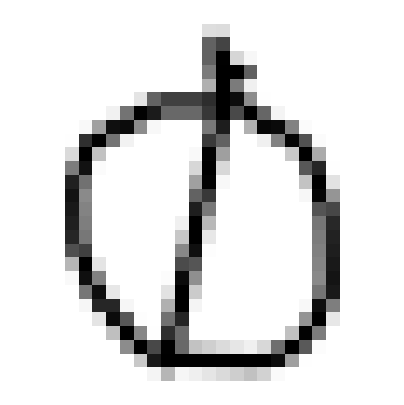

In [422]:
plot(5230)

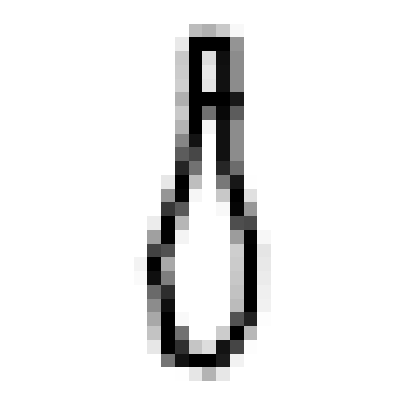

In [274]:
plot(28936)

In [101]:
base_df = pd.read_csv('base_slim.csv').set_index('idx')

In [278]:
result

{28936: 0.0,
 296711: 4.314758,
 234421: 4.377256,
 227181: 4.517256,
 53840: 4.9110785,
 50290: 5.057594,
 265075: 5.067576,
 84628: 5.1861467,
 93576: 5.1909914,
 212947: 5.2403073,
 82635: 5.3019013,
 19929: 5.306104,
 168020: 5.3273034,
 16851: 5.3508883,
 96027: 5.3643146,
 270179: 5.3904495,
 111591: 5.3980203,
 207511: 5.4266167,
 8049: 5.44813,
 281649: 5.4511623,
 298822: 5.4653883,
 138613: 5.4933286,
 244786: 5.510189,
 136751: 5.5234957,
 295615: 5.56768,
 218124: 5.5949078,
 239171: 5.6312184,
 240077: 5.6461277,
 256924: 5.693788,
 207338: 5.7429223,
 226529: 5.775344,
 98690: 5.833494,
 141661: 5.865529,
 38455: 5.884656,
 113616: 5.920727,
 47921: 5.9278812,
 87700: 5.9308767,
 91860: 5.940635,
 147561: 5.955179,
 279771: 5.9717097,
 285673: 5.978845,
 116365: 5.990739,
 250119: 6.004822,
 126874: 6.050519,
 244181: 6.0873866,
 45144: 6.1164417,
 153915: 6.1218925,
 150917: 6.1258407,
 83215: 6.126088,
 162429: 6.1396275,
 7504: 6.172438,
 80073: 6.18035,
 223308: 6.190

In [106]:
index = 110635

all_layers = {}
for layer in range(14):
    
    idx = base_df.loc[index].name
    x = val_data[idx][0]
    subject_rep = model[:layer](torch.tensor(x).unsqueeze(1)).detach().numpy()
    
    result = {}
    for n in tqdm(base_df.loc[index][layer*1000 : (layer+1)*1000]):
        idx = base_df.iloc[n].name
        x = val_data[idx][0]
        rep = model[:layer](torch.tensor(x).unsqueeze(1)).detach().numpy()
        d = np.linalg.norm(subject_rep.flatten() - rep.flatten())
        result[idx] = d
    all_layers[layer] = result
    
all_layers

NameError: name 'tqdm' is not defined

In [360]:
idx = 2399

labels = [
    'airplane',
    'apple',
    'bee',
    'car',
    'dragon',
    'mosquito',
    'moustache',
    'mouth',
    'pear',
    'piano',
    'pineapple',
    'smiley face',
    'train',
    'umbrella',
    'wine bottle'
]

distances_dfs = {}
for layer in range(14):
    x = val_data[idx][0]
    subject_rep = model[:layer](torch.tensor(x).unsqueeze(1)).detach().numpy()

    result = []
    for idx, item in tqdm(enumerate(val_data)):
        x = item[0]
        y = item[1]
        rep = model[:layer](torch.tensor(x).unsqueeze(1)).detach().numpy()
        d = np.linalg.norm(subject_rep.flatten() - rep.flatten())
        result.append([idx, d, labels[y]])

    distances_df = pd.DataFrame(result, columns = ["idx", "d", "label"])
    distances_dfs[layer] = distances_df

300000it [00:03, 82087.97it/s]
300000it [00:26, 11499.08it/s]
300000it [00:28, 10705.27it/s]
300000it [00:48, 6220.30it/s]
300000it [01:11, 4178.59it/s]
300000it [01:19, 3768.31it/s]
300000it [01:33, 3208.85it/s]
300000it [01:56, 2570.26it/s]
300000it [01:58, 2521.43it/s]
300000it [02:22, 2102.84it/s]
300000it [02:28, 2020.75it/s]
300000it [02:28, 2018.44it/s]
300000it [02:45, 1811.01it/s]
300000it [02:35, 1924.48it/s]


In [304]:
distances_df = pd.DataFrame(result, columns = ["idx", "d", "label"])

In [ ]:
val_data[2399][0]

In [209]:
sample = 110635
order = np.array([
    'train',
    'mosquito',
    'airplane',
    'pineapple',
    'wine bottle',
    'car',
    'bee',
    'apple',
    'dragon',
    'moustache',
    'mouth',
    'pear',
    'piano',
    'smiley face',
    'umbrella',
])

while labels[val_data[sample][1]] != order[0]:
        order = np.roll(order, 1)

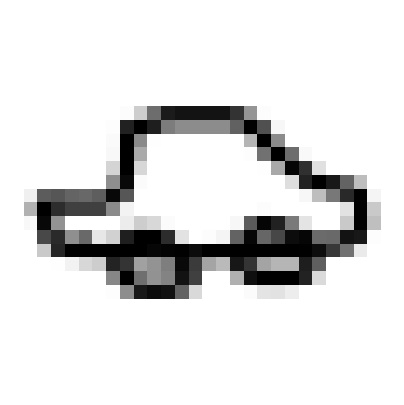

In [211]:
plot(110635)

In [210]:
order

array(['car', 'bee', 'apple', 'dragon', 'moustache', 'mouth', 'pear',
       'piano', 'smiley face', 'umbrella', 'train', 'mosquito',
       'airplane', 'pineapple', 'wine bottle'], dtype='<U11')

In [212]:
samples = [
    110635,
    101647,
    272791,
    271551,
    185767,
    146028,
    115656
]

order = np.array([
    'train',
    'mosquito',
    'airplane',
    'pineapple',
    'wine bottle',
    'car',
    'bee',
    'apple',
    'dragon',
    'moustache',
    'mouth',
    'pear',
    'piano',
    'smiley face',
    'umbrella',
])

for sample in samples:

    labels = [
        'airplane',
        'apple',
        'bee',
        'car',
        'dragon',
        'mosquito',
        'moustache',
        'mouth',
        'pear',
        'piano',
        'pineapple',
        'smiley face',
        'train',
        'umbrella',
        'wine bottle'
    ]


    overall = []
    for idx, item in tqdm(enumerate(val_data)):

        sub = val_data[sample][0]
        subject_rep = torch.tensor(sub).unsqueeze(1)

        x = item[0]
        y = item[1]
        rep = torch.tensor(x).unsqueeze(1)

        result = [idx, labels[y]]
        
        d = np.linalg.norm(subject_rep.detach().numpy().flatten() - rep.detach().numpy().flatten())
        result.append(d)
        
        for layer in range(13):
            subject_rep = model[layer](subject_rep)
            rep = model[layer](rep)

            d = np.linalg.norm(subject_rep.detach().numpy().flatten() - rep.detach().numpy().flatten())
            result.append(d)

        overall.append(result)


    distances_df = pd.DataFrame(overall, columns = ["idx", "label"] + ["d"+str(i) for i in range(14)])
    
    norm_dist_df = (distances_df.filter(regex="d.*")-distances_df.filter(regex="d.*").min())/(distances_df.filter(regex="d.*").max()-distances_df.filter(regex="d.*").min())
    norm_dist_df["label"] = distances_df.label
    norm_dist_df.idx = distances_df.idx
    
    
    while labels[val_data[sample][1]] != order[0]:
        order = np.roll(order, 1)
        
    colors = ["#999" for _ in range(15)]
    colors[0] = "#FF0B04"
    for layer in range(14):
        sns_plot = sns.kdeplot(data=norm_dist_df, x=("d"+str(layer)), hue="label", hue_order = order, palette=colors, legend=False)
        fig = sns_plot.get_figure()
        plt.axis(False)
        fig.savefig("./dist2/"+str(sample)+'-layer'+str(layer)+'.svg')
        fig.clf()

        

300000it [06:24, 780.86it/s]
300000it [06:25, 779.18it/s]
300000it [06:32, 764.38it/s]
300000it [06:11, 806.50it/s]
300000it [06:18, 792.20it/s]
300000it [06:25, 777.64it/s]
300000it [06:55, 722.82it/s]


<Figure size 640x480 with 0 Axes>

In [202]:

#norm_dist_df = (distances_df.filter(regex="d.*")-distances_df.filter(regex="d.*").mean())/distances_df.filter(regex="d.*").std()
norm_dist_df = (distances_df.filter(regex="d.*")-distances_df.filter(regex="d.*").min())/(distances_df.filter(regex="d.*").max()-distances_df.filter(regex="d.*").min())
norm_dist_df["label"] = distances_df.label
norm_dist_df.idx = distances_df.idx


In [203]:
norm_dist_df.loc[[
    110635,
 101647,
 272791,
 271551,
 185767,
 146028,
 115656,
]]

,idx,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,label
110635,110635,0.790159,0.757718,0.824702,0.711589,0.605253,0.775555,0.759866,0.602802,0.659297,0.659297,0.629365,0.610169,0.673934,car
101647,101647,0.752207,0.720360,0.785301,0.659019,0.590012,0.730030,0.701379,0.609514,0.693005,0.693005,0.666005,0.627542,0.640236,wine bottle
272791,272791,0.880567,0.867227,0.895361,0.727249,0.670848,0.809913,0.821998,0.698784,0.750862,0.750862,0.698552,0.734386,0.615848,bee
271551,271551,0.766559,0.745533,0.788106,0.664793,0.594544,0.735121,0.687091,0.580743,0.629081,0.629081,0.573801,0.540375,0.492113,mosquito
185767,185767,0.740554,0.741658,0.757794,0.655003,0.602470,0.717494,0.687747,0.626013,0.671829,0.671829,0.574978,0.528350,0.458432,pineapple
146028,146028,0.865250,0.835577,0.892740,0.759496,0.654215,0.797496,0.769334,0.664222,0.716912,0.716912,0.656307,0.623125,0.428567,airplane
115656,115656,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,train


In [119]:
layers = [
        'Conv2d(1, 16, 3)',
        'relu1',
        'maxpool1',
        'Conv2d(16, 32, 3)',
        'relu2',
        'maxpool2',
        'Conv2d(32, 32, 3)',
        'relu3',
        'maxpool3',
        'flatten',
        'Linear(288, 128)',
        'relu4',
        'Linear(128, len(classes))',
     ]

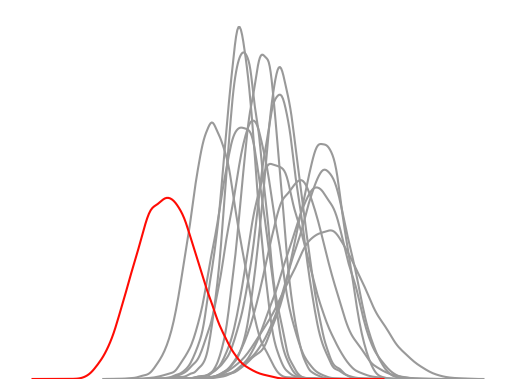

In [158]:
colors = ["#999" for _ in range(15)]
colors[0] = "#FF0B04"
sns.kdeplot(data=norm_dist_df, x=("d12"), hue="label", palette=colors, legend=False)
plt.axis(False)


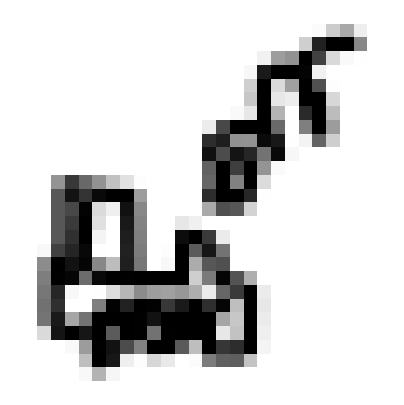

In [204]:
plot(115656)

In [205]:
# just make sure the correct class is at index 0
order = [
    'train',
    'mosquito',
    'airplane',
    'pineapple',
    'wine bottle',
    'car',
    'bee',
    'apple',
    'dragon',
    'moustache',
    'mouth',
    'pear',
    'piano',
    'smiley face',
    'umbrella',
]

In [206]:
colors = ["#999" for _ in range(15)]
colors[0] = "#FF0B04"
for layer in range(13):
    sns_plot = sns.kdeplot(data=norm_dist_df, x=("d"+str(layer)), hue="label", hue_order = order, palette=colors, legend=False)
    fig = sns_plot.get_figure()
    plt.axis(False)
    fig.savefig("./distdev/"+'115656-layer'+str(layer)+'.svg')
    fig.clf()
    


<Figure size 640x480 with 0 Axes>

In [473]:
for layer in range(13):
    sns_plot = sns.histplot(data=distances_dfs[layer], x="d", hue="label", multiple="stack", palette=sns.color_palette())
    fig = sns_plot.get_figure()
    fig.savefig("./distdev/"+str(layer)+".pdf")
    fig.clf()
    


KeyError: 0

In [185]:
[str(j) + "-" +str(i) for j in range(13) for i in range(10000)][-55]

'12-9945'

In [162]:
pd.DataFrame(base_df.filter(regex=("b.*-12")), base_slim)

ValueError: Index data must be 1-dimensional

In [150]:
help(base_slim)

Help on DataFrame in module pandas.core.frame object:

class DataFrame(pandas.core.generic.NDFrame, pandas.core.arraylike.OpsMixin)
 |  DataFrame(data=None, index: 'Axes | None' = None, columns: 'Axes | None' = None, dtype: 'Dtype | None' = None, copy: 'bool | None' = None) -> 'None'
 |  
 |  Two-dimensional, size-mutable, potentially heterogeneous tabular data.
 |  
 |  Data structure also contains labeled axes (rows and columns).
 |  Arithmetic operations align on both row and column labels. Can be
 |  thought of as a dict-like container for Series objects. The primary
 |  pandas data structure.
 |  
 |  Parameters
 |  ----------
 |  data : ndarray (structured or homogeneous), Iterable, dict, or DataFrame
 |      Dict can contain Series, arrays, constants, dataclass or list-like objects. If
 |      data is a dict, column order follows insertion-order. If a dict contains Series
 |      which have an index defined, it is aligned by its index.
 |  
 |      .. versionchanged:: 0.25.0
 | 

In [194]:
base_df

,Unnamed: 0,0-0,0-1,0-2,0-3,0-4,0-5,0-6,0-7,0-8,...,13-990,13-991,13-992,13-993,13-994,13-995,13-996,13-997,13-998,13-999
0,0,0,2130,6194,1320,1892,3228,6036,8803,389,...,9151,7566,7398,5225,8900,5954,5925,154,3525,694
1,1,1,645,7268,6076,41,5105,4562,6872,3236,...,5793,9794,7711,6854,1219,1682,6850,2015,539,8074
2,2,2,7998,3924,4657,7506,3808,331,66,6686,...,9766,7973,4543,2517,3704,3578,5894,3877,8592,3508
3,3,3,5905,3059,6167,2582,7132,6076,8601,3524,...,7796,5098,9291,5547,838,5934,8799,4623,8796,3957
4,4,4,2989,6765,3786,4712,1984,8964,4451,9811,...,2294,1333,4648,5937,4531,6464,4869,8970,5314,4513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,9995,6265,9224,3711,5016,6803,9503,2649,6203,...,1955,6500,3386,481,401,2637,5354,3271,5413,9837
9996,9996,9996,251,9432,1008,3166,9,8663,2757,1954,...,6488,8011,1993,1728,4054,8341,3445,883,1544,7715
9997,9997,9997,4089,4570,2029,3987,428,9882,6381,4642,...,2563,5918,7049,1761,1959,7806,3274,8738,5993,7519
9998,9998,9998,8153,9973,236,1935,7059,7268,7820,9717,...,5808,7389,2854,575,3436,3379,5188,9521,7991,3058


In [188]:
base_slim.rename(columns = dict(zip(base_slim.columns, [str(j) + "-" +str(i) for j in range(15) for i in range(1000)]))).to_csv('base_slim.csv')



In [196]:
base_slim.iloc[]

,a0-0,a1-0,a2-0,a3-0,a4-0,a5-0,a6-0,a7-0,a8-0,a9-0,...,b990-12,b991-12,b992-12,b993-12,b994-12,b995-12,b996-12,b997-12,b998-12,b999-12
0,0,2130,6194,1320,1892,3228,6036,8803,389,9653,...,9151,7566,7398,5225,8900,5954,5925,154,3525,694
1,1,645,7268,6076,41,5105,4562,6872,3236,3610,...,5793,9794,7711,6854,1219,1682,6850,2015,539,8074
2,2,7998,3924,4657,7506,3808,331,66,6686,5064,...,9766,7973,4543,2517,3704,3578,5894,3877,8592,3508
3,3,5905,3059,6167,2582,7132,6076,8601,3524,4435,...,7796,5098,9291,5547,838,5934,8799,4623,8796,3957
4,4,2989,6765,3786,4712,1984,8964,4451,9811,5133,...,2294,1333,4648,5937,4531,6464,4869,8970,5314,4513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,6265,9224,3711,5016,6803,9503,2649,6203,4688,...,1955,6500,3386,481,401,2637,5354,3271,5413,9837
9996,9996,251,9432,1008,3166,9,8663,2757,1954,2315,...,6488,8011,1993,1728,4054,8341,3445,883,1544,7715
9997,9997,4089,4570,2029,3987,428,9882,6381,4642,6845,...,2563,5918,7049,1761,1959,7806,3274,8738,5993,7519
9998,9998,8153,9973,236,1935,7059,7268,7820,9717,3921,...,5808,7389,2854,575,3436,3379,5188,9521,7991,3058


In [540]:
l = [12,6,4,2]
x = {23: 23, 2323: 30}

In [541]:
l.extend(list(x.keys()))

In [542]:
l

[12, 6, 4, 2, 23, 2323]